# Lab 3 (Feb 2): Support Vector Machine

Support vector machine works well for linear separation problem and it can be generalized to non-linear separation problem (kernel trick next week).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Generate data set  (linear separable)

In [ ]:
np.random.seed(1)

## class 1: -1
m0 = 100
X0_x = np.random.uniform(0,1,m0)                               # abscissae of the blue dots
X0_y = 3/2*X0_x + 1/2 + np.random.normal(0,0.2,m0)             # their ordinates
X0 = np.column_stack((X0_x,X0_y))

## class 2: +1
m1 = 50
X1_x = np.random.uniform(1,2,m1)                               # abscissae of the red crosses
X1_y = np.random.uniform(0,1,m1)                               # their ordinates
X1 = np.column_stack((X1_x,X1_y))

## visualize
plt.plot(X0[:,0],X0[:,1],'b.',X1[:,0],X1[:,1],'r+',markerfacecolor='none',markersize=8)
plt.legend(['-1','+1'])
plt.xticks([])
plt.yticks([])
plt.show()

### Linear feasibility program

The optimization problem (4.2) in the textbook is

$$ \mathop{\mathrm{minimize}}_{w\in\mathbb{R}^d, b\in\mathbb{R}} 1 \quad \mbox{ subject to } y_i(\langle w, x^{(i)}\rangle-b)\geq1 \quad  \mbox{ for all } i\in[1 : m]$$.

Then, it can be reformalized as

$$ \mathop{\mathrm{minimize}}_{\tilde{w}\in\mathbb{R}^{d+1}} \quad 0 \quad \mbox{ subject to } \tilde{X} \tilde{w} \leq z,$$ where 
$$ \tilde{X} = \begin{bmatrix} -X0 && | && -1 \\ X1 && | && 1\end{bmatrix} \quad \tilde{w} = [w;-b]\in\mathbb{R}^{d+1} \quad z = \begin{bmatrix} -1 \\ \vdots \\ -1\end{bmatrix}\in\mathbb{R}^m$$

In [ ]:
from scipy.optimize import linprog
# create a dummy objective function
c = [0,0,0]
# create the inequality constraints (of type Az <= b)
X0_tilde = np.column_stack((X0,np.ones((m0,1))))
X1_tilde = np.column_stack((X1,np.ones((m1,1))))
A = np.row_stack( (-X0_tilde,X1_tilde) )
b = -np.ones(m0+m1)
# solve the linear program
res = linprog(c, A_ub=A, b_ub=b, bounds=(None,None))
w_feas = res.x[0:2]
b_feas = -res.x[2]

In [ ]:
# visualize the "hyperplane" produced by a linear feasibility program (in black)
grid_x = np.linspace(0,2,20)
plt.plot(X0[:,0],X0[:,1],'b.',X1[:,0],X1[:,1],'r+',markerfacecolor='none',markersize=8)
plt.plot(grid_x,(-w_feas[0]*grid_x+b_feas)/w_feas[1],'k-.')
plt.xticks([])
plt.yticks([])
plt.show()

### Perceptron algorithm

In [ ]:
from numpy import linalg as LA

X_tilde = np.row_stack((X0_tilde,X1_tilde))
y = np.row_stack((-np.ones((m0,1)),np.ones((m1,1))))
w_tilde = np.zeros((3,1))
obj_perc = y*(X_tilde@w_tilde)    # to be entrywise positive at the end of the loop
while min(obj_perc)<=0:
    i = np.argmin(obj_perc)
    w_tilde = w_tilde + (y[i]/LA.norm(X_tilde[i,:])**2)*np.transpose([X_tilde[i,:]])
    obj_perc = y*(X_tilde@w_tilde)
w_perc = w_tilde[0:2]
b_perc = -w_tilde[2]

# visualize the "hyperplane" produced by the perceptrom algorithm (in green)    
plt.plot(X0[:,0],X0[:,1],'b.',X1[:,0],X1[:,1],'r+',markerfacecolor='none',markersize=8,label='_nolegend_')
plt.plot(grid_x,(-w_feas[0]*grid_x+b_feas)/w_feas[1],'k-.')
plt.plot(grid_x,(-w_perc[0]*grid_x+b_perc)/w_perc[1],'g')
plt.legend(['Linear feasible','perceptron algorithm'])
plt.ylim((-0.2,2.5))
plt.xticks([])
plt.yticks([])
plt.show()

### Hard SVM

The optimization problem (4.3) in the textbook, called Hard SVM, is 

$$ \mathop{\mathrm{minimize}}_{w\in\mathbb{R}^d, b\in\mathbb{R}} \|w\|_2 \quad \mbox{ subject to } y_i(\langle w, x^{(i)}\rangle-b)\geq1 \quad  \mbox{ for all } i\in[1 : m]$$.

In [2]:
import cvxpy as cp

In [ ]:
# define the variables
w = cp.Variable(2)
b = cp.Variable(1)
# define the objective function
objective = cp.Minimize(cp.norm(w))
# define the inequality constraints
constraints = [X0@w - b <= -1]
constraints += [X1@w - b >= 1]
# solve the optimization problem
hard_SVM = cp.Problem(objective, constraints)
hard_SVM.solve()
w_hsvm = w.value
b_hsvm = b.value

In [ ]:
# visualize the "hyperplane" produced by hard SVM (in magenta)
grid_x = np.linspace(0,2,20)
plt.plot(X0[:,0],X0[:,1],'b.',X1[:,0],X1[:,1],'r+',markerfacecolor='none',markersize=8,label='_nolegend_')
plt.plot(grid_x,(-w_feas[0]*grid_x+b_feas)/w_feas[1],'k-.')
plt.plot(grid_x,(-w_perc[0]*grid_x+b_perc)/w_perc[1],'g')
plt.plot(grid_x,(-w_hsvm[0]*grid_x+b_hsvm)/w_hsvm[1],'m--')
plt.legend(['Linear feasible','perceptron algorithm','Hard SVM'])
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
from sklearn.svm import LinearSVC

X_tilde = np.row_stack((X0,X1))
y = np.row_stack((-np.ones((m0,1)),np.ones((m1,1))))

clf = LinearSVC(C=1e20,loss="hinge")
clf.fit(X_tilde,y)

w_clf = clf.coef_[0]
b_clf = clf.intercept_[0]
## Remark: The smaller C allows more misclassficiation, while the larger C leads to less misclassification

In [ ]:
grid_x = np.linspace(0,2,20)
plt.plot(X0[:,0],X0[:,1],'b.',X1[:,0],X1[:,1],'r+',markerfacecolor='none',markersize=8,label='_nolegend_')
plt.plot(grid_x,(-w_hsvm[0]*grid_x+b_hsvm)/w_hsvm[1],'m--')
plt.plot(grid_x,(-w_clf[0]*grid_x-b_clf)/w_clf[1],'r')
plt.legend(['Hard SVM','sklearn'])
#plt.xticks([])
#plt.yticks([])
plt.show()

In [ ]:
# prediction
x_new_1 = [1,0.5]
y_new_1 = clf.predict([x_new_1])[0]
print( 'If new data is [1,0.5], the predict class is {:d}'.format(int(y_new_1)) )



In [ ]:
x_new_1 = [1,0.5]
y_new_1 = clf.predict([x_new_1])
y_new_1[0]

In [ ]:
x_new_2 = [1,3.5]
y_new_2 = clf.predict([x_new_2])[0]
print( 'If new data is [1,3.5], the predict class is {:d}'.format(int(y_new_2)) )

## The case of two almost linearly separable classes

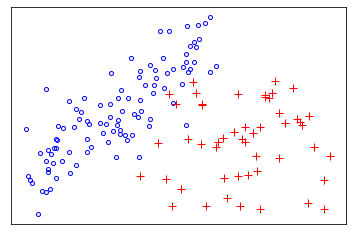

In [3]:
# generate the data 
m0 = 100
m1 = 50
X0_x = np.random.uniform(0,1,m0)                                  # abscissae of the blue dots
X0_y = X0_x + 1/4 + np.random.normal(0,0.2,m0)                    # their ordinates
X0 = np.column_stack((X0_x,X0_y))
X1_x = np.random.uniform(0.6,1.6,m1)                              # abscissae of the red crosses
X1_y = np.random.uniform(0,1,m1)                                  # their ordinates
X1 = np.column_stack((X1_x,X1_y))
plt.plot(X0[:,0],X0[:,1],'b.',X1[:,0],X1[:,1],'r+',markerfacecolor='none',markersize=8)
plt.xticks([])
plt.yticks([])
plt.show()

The optimization problem (4.3) in the textbook, called soft SVM, is 

$$ \mathop{\mathrm{minimize}}_{w\in\mathbb{R}^d, b\in\mathbb{R},\xi\in\mathbb{R}^m} \|w\|_2+\frac{1}{\lambda}\sum_{i=1}^{m}\xi_i \quad \mbox{ subject to } y_i(\langle w, x^{(i)}\rangle-b)\geq1-\xi_i \mbox{ and } \xi_i\geq0 \quad  \mbox{ for all } i\in[1 : m]$$.

In [4]:
# define the variables
w = cp.Variable(2)
b = cp.Variable(1)
xi = cp.Variable(m0+m1,pos=True)
# define the objective function
lamb = 1e-3
objective = cp.Minimize(cp.norm(w)+cp.sum(xi)/lamb)
# define the inequality constraints
constraints = [ X0@w - b <= -1+xi[0:m0] ]
constraints += [X1@w - b >= 1-xi[m0:m0+m1]]
# solve the optimization problem
soft_SVM = cp.Problem(objective, constraints)
soft_SVM.solve()
w_ssvm = w.value
b_ssvm = b.value

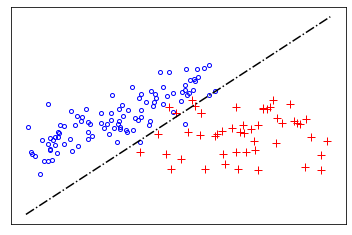

In [5]:
# visualize the "hyperplane" produced by soft SVM
grid_x = np.linspace(0,1.6,20)
plt.plot(X0[:,0],X0[:,1],'b.',X1[:,0],X1[:,1],'r+',markerfacecolor='none',markersize=8)
plt.plot(grid_x,(-w_ssvm[0]*grid_x+b_ssvm)/w_ssvm[1],'k-.')
plt.xticks([])
plt.yticks([])
plt.show()

In [8]:
from sklearn.svm import LinearSVC

X_tilde = np.row_stack((X0,X1))
y = np.row_stack((-np.ones((m0,1)),np.ones((m1,1))))

clf = LinearSVC(C=1,loss="hinge")
clf.fit(X_tilde,y)

w_clf = clf.coef_[0]
b_clf = clf.intercept_[0]

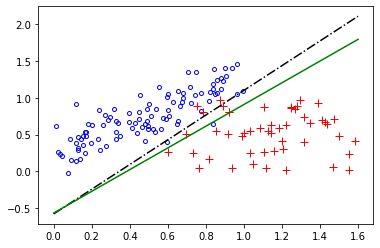

In [9]:
grid_x = np.linspace(0,1.6,20)
plt.plot(X0[:,0],X0[:,1],'b.',X1[:,0],X1[:,1],'r+',markerfacecolor='none',markersize=8)
plt.plot(grid_x,(-w_ssvm[0]*grid_x+b_ssvm)/w_ssvm[1],'k-.')
plt.plot(grid_x,(-w_clf[0]*grid_x-b_clf)/w_clf[1],'g-')
#plt.xticks([])
#plt.yticks([])
plt.show()